In [1]:
import mne
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

from himalaya.backend import set_backend, get_backend
from himalaya.scoring import correlation_score

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import os

In [31]:
brain_data_path = "/srv/nfs-data/sisko/matteoc/meg/save_brains"
stimulus_data_path = "/srv/nfs-data/sisko/matteoc/meg/save_stimulus"

brain_data = torch.load(os.path.join(brain_data_path, 'brain_tensor_subject_04.pt'))
audio_data = torch.load(os.path.join(stimulus_data_path, 'stft_tensor.pt'))

# AVG SESSIONS
n_samples = brain_data.shape[0] // 2
brain_data = (brain_data[:n_samples] + brain_data[n_samples:]) / 2
audio_data = audio_data[:n_samples]

/tmp/ipykernel_1606438/193776580.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  brain_data = torch.load(os.path.join(brain_data_path, 'brain_tensor_subject_04.pt'))
/tm

In [32]:
print("Brain data shape:", brain_data.shape)
print("Audio data shape:", audio_data.shape)

Brain data shape: torch.Size([8561, 208, 401])
Audio data shape: torch.Size([8561, 257, 126])


In [33]:
X = audio_data.reshape(audio_data.shape[0], -1)  
Y = brain_data.reshape(brain_data.shape[0], -1) 

X.shape, Y.shape

(torch.Size([8561, 32382]), torch.Size([8561, 83408]))

In [34]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
from sklearn.model_selection import train_test_split

inner_cv = KFold(n_splits=5, shuffle=False) 
model = make_pipeline(
    RidgeCV(alphas=[0.01,1,10,20,1e2,1e3], fit_intercept=True, cv=inner_cv) 
)
model

Pipeline(steps=[('ridgecv',
                 RidgeCV(alphas=[0.01, 1, 10, 20, 100.0, 1000.0],
                         cv=KFold(n_splits=5, random_state=None, shuffle=False),
                         fit_intercept=True))])

In [35]:
import tqdm

epochs_shape = brain_data.shape[1:] # number of electrodes * number of lags
print(f"Epochs shape: {epochs_shape}")

def train_encoding(X, Y):

    corrs = []
    preds = [] 
    kfold = KFold(2, shuffle=False) 
    for train_index, test_index in tqdm.tqdm(kfold.split(X)): 

        X1_train, X1_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        scaler = StandardScaler()
        Y_train = scaler.fit_transform(Y_train)
        Y_test = scaler.transform(Y_test)

        device_id = 3 
        torch.cuda.set_device(device_id)  
        backend = set_backend("torch_cuda")

        X1_train = backend.asarray(X1_train).to(f'cuda:{device_id}')
        Y_train = backend.asarray(Y_train).to(f'cuda:{device_id}')
        X1_test = backend.asarray(X1_test).to(f'cuda:{device_id}')
        Y_test = backend.asarray(Y_test).to(f'cuda:{device_id}')

        model.fit(X1_train, Y_train) 
        Y_preds = model.predict(X1_test)
        corr = correlation_score(Y_test, Y_preds).reshape(epochs_shape) 

        if "torch" in get_backend().__name__: 
            corr = corr.numpy(force=True)

        corrs.append(corr) 
        preds.append(Y_preds)
    return np.stack(corrs), np.concatenate(preds, axis=0).reshape(-1, *epochs_shape)

corrs_embedding, pred_brains = train_encoding(X, Y)
print(f"Encoding performance correlating matrix shape: {corrs_embedding.shape}")
print(f"Predicted matrix shape: {pred_brains.shape}")


Epochs shape: torch.Size([208, 401])


0it [00:00, ?it/s]/home/matteoc/miniconda3/envs/huggin/lib/python3.11/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 4280 < 32382). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(
1it [00:24, 24.60s/it]/home/matteoc/miniconda3/envs/huggin/lib/python3.11/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 4281 < 32382). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(
2it [00:49, 24.84s/it]


Encoding performance correlating matrix shape: (2, 208, 401)
Predicted matrix shape: (8561, 208, 401)


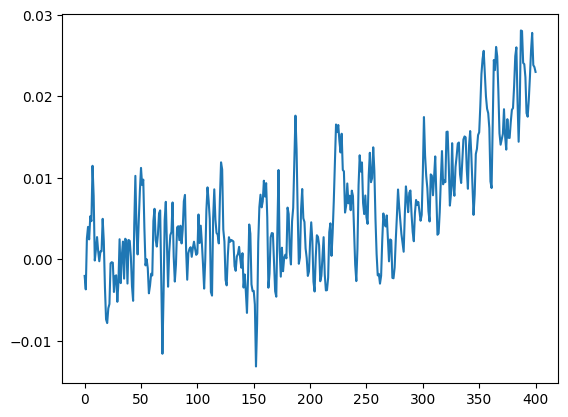

In [36]:
plt.plot(corrs_embedding.mean((0,1)))

In [37]:
device = 3
n_permutations = 500
n_samples, n_channels, n_timepoints = pred_brains.shape

def batch_pearson_corr(x, y, dim=1):
    """Pearson correlation per batch lungo dim specificata"""
    x_centered = x - x.mean(dim=dim, keepdim=True)
    y_centered = y - y.mean(dim=dim, keepdim=True)
    numerator = (x_centered * y_centered).sum(dim=dim)
    denominator = torch.sqrt((x_centered**2).sum(dim=dim) * (y_centered**2).sum(dim=dim))
    return numerator / (denominator + 1e-8)

pred_brains_torch = torch.tensor(pred_brains, device=device)
brain_data_torch = torch.tensor(brain_data, device=device)

null_distribution_tp = torch.zeros((n_permutations, n_timepoints), device=device)
null_distribution_ch = torch.zeros((n_permutations, n_channels), device=device)

for perm in tqdm.tqdm(range(n_permutations), desc="Permutation runs"):
    shuffled_idx = torch.randperm(n_samples, device=device)
    y_true_perm = brain_data_torch[shuffled_idx]

    for tp in range(n_timepoints):
        corrs = batch_pearson_corr(pred_brains_torch[:, :, tp], y_true_perm[:, :, tp], dim=1)
        null_distribution_tp[perm, tp] = corrs.mean()

    for ch in range(n_channels):
        corrs_ch = batch_pearson_corr(pred_brains_torch[:, ch, :], y_true_perm[:, ch, :], dim=1)
        null_distribution_ch[perm, ch] = corrs_ch.mean()

null_distribution_tp = null_distribution_tp.cpu().numpy()
null_distribution_ch = null_distribution_ch.cpu().numpy()



/tmp/ipykernel_1606438/1687232051.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  brain_data_torch = torch.tensor(brain_data, device=device)
Permutation runs: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


In [38]:
null_distribution_tp.shape, null_distribution_ch.shape

((500, 401), (500, 208))

In [39]:
real_corr_tp = corrs_embedding.mean((0,1))
real_corr_ch = corrs_embedding.mean((0,2))
p_values_tp = np.mean(null_distribution_tp >= real_corr_tp[None, :], axis=0)  
p_values_ch = np.mean(null_distribution_ch >= real_corr_ch[None, :], axis=0) 

In [40]:
from statsmodels.stats.multitest import fdrcorrection

significant_tp, pvals_corrected_tp = fdrcorrection(p_values_tp, alpha=0.05)
significant_ch, pvals_corrected_ch = fdrcorrection(p_values_ch, alpha=0.05)

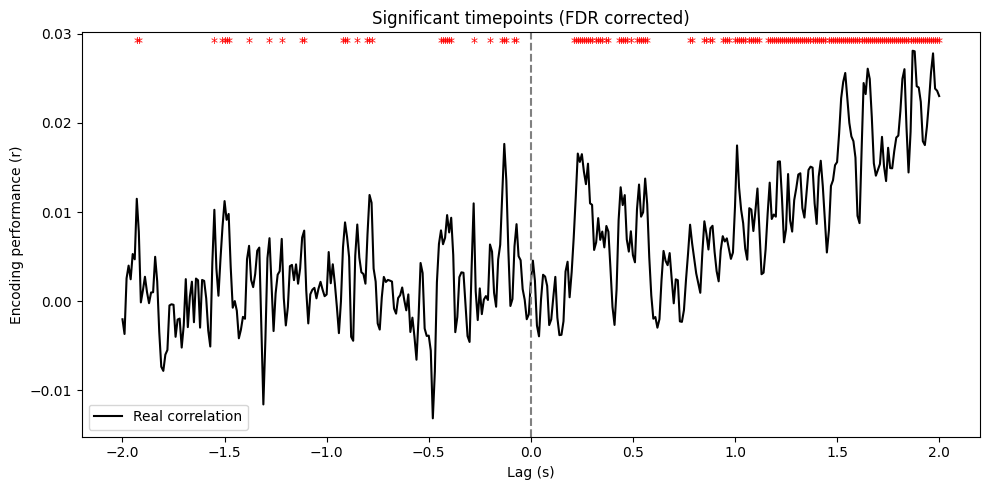

In [42]:
import matplotlib.pyplot as plt

lags = np.linspace(-2.0, 2.0, corrs_embedding.shape[-1])  # Assicurati sia coerente

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(lags, real_corr_tp, color='black', label='Real correlation')
ax.axvline(0, color='gray', linestyle='--')
y_top = real_corr_tp.max() + 0.0001
# Aggiungi asterischi nei timepoint significativi
for t, sig in enumerate(significant_tp):
    if sig:
        ax.text(lags[t], y_top, '*', color='red', fontsize=10,
                ha='center', va='bottom')

ax.set_xlabel('Lag (s)')
ax.set_ylabel('Encoding performance (r)')
ax.set_title('Significant timepoints (FDR corrected)')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # solo per compatibilità, non usato direttamente

def plot_3d_topomap(raw, correlations, cmap='RdBu_r', label_to_set='Correlation'):
    meg_indices = mne.pick_types(raw.info, meg=True)
    meg_channel_positions = np.array([raw.info['chs'][i]['loc'][:3] for i in meg_indices])
    correlations = np.array(correlations).reshape(-1)

    # Normalizza per mappare su colormap
    norm_corr = (correlations - np.nanmin(correlations)) / (np.nanmax(correlations) - np.nanmin(correlations))
    colors = cm.get_cmap(cmap)(norm_corr)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot 3D scatter con colori da colormap
    for i, (pos, col) in enumerate(zip(meg_channel_positions, colors)):
        ax.scatter(*pos, color=col, s=60)
        ax.text(*pos, raw.info['ch_names'][meg_indices[i]], fontsize=6)

    ax.set_title('MEG 3D topomap')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Mappa colore per la colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(correlations)  # valori grezzi, non normalizzati
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label(label_to_set)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1606438/159429830.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)(norm_corr)


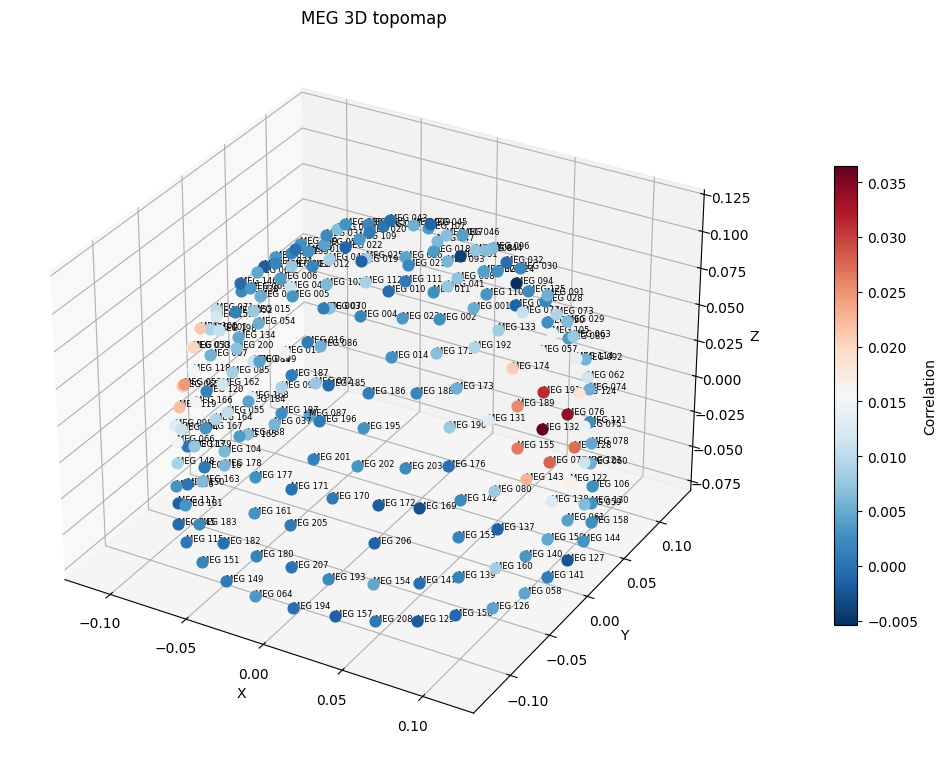

In [72]:
plot_3d_topomap(raw, real_corr_ch, cmap='RdBu_r', label_to_set='Correlation')


In [ ]:
# from param_funct import get_bids_raw
# from scipy.stats import zscore
# from functools import partial

# meg_path = '/srv/nfs-data/sisko/matteoc/meg'
# meg_path_data = os.path.join(meg_path, 'MEG_DATA/osfstorage')
# raw = get_bids_raw(meg_path_data, '13', '0', '0')
# func = partial(zscore)
# raw.load_data(verbose=False)
# raw = raw.apply_function(func, channel_wise=False, verbose=False)

# ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
# coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
# coords *= 1000  # nilearn likes to plot in meters, not mm
# print("Coordinate matrix shape: ", coords.shape)

# order = real_corr_ch.argsort()
# plot_markers(real_corr_ch[order], coords[order],
#              node_size=30, display_mode='lzr',
#              node_vmin=0, node_cmap='inferno_r', colorbar=True)
# plt.show()

In [8]:
# STFT --> ok, c'è segnale da onset che sale
# W2V --> ok, c'è segnale da onset che sale (sale un po' prima, correlazione più bassa di stft)
# GPT2 --> ok, c'è segnale da onset che sale (simile a sftf, correlazione più alta in media)

## Load Results

In [86]:
import numpy as np
import os
import glob

def load_corrs_and_masks(results_dir):
    corrs_list, ch_masks, tp_masks = [], [], []

    corrs_paths = sorted(glob.glob(os.path.join(results_dir, 'corrs_embedding_*.npy')))
    for path in corrs_paths:
        subj_idx = path.split('_')[-1].split('.')[0]
        corr = np.load(path)  # shape: (n_folds, n_channels, n_timepoints)

        ch_mask = np.load(os.path.join(results_dir, f'significant_ch_{subj_idx}.npy'))
        tp_mask = np.load(os.path.join(results_dir, f'significant_tp_{subj_idx}.npy'))

        corrs_list.append(corr)
        ch_masks.append(ch_mask)
        tp_masks.append(tp_mask)

    return corrs_list, ch_masks, tp_masks


def plot_timecourse(corrs_list, ch_masks, tp_masks, lags=None, tp_thresh=0.5):
    all_corrs = []
    for corr, ch_mask in zip(corrs_list, ch_masks):
        mean_corr = np.mean(corr[:, ch_mask, :], axis=(0, 1))
        masked_lags = np.linspace(-2.0, 2.0, corr.shape[-1]) if lags is None else lags
        all_corrs.append(mean_corr)

    real_corr_tp = np.mean(all_corrs, axis=0)  # media tra soggetti

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(masked_lags, real_corr_tp, color='black', label='Real correlation')
    ax.axvline(0, color='gray', linestyle='--')
    y_top = real_corr_tp.max() + 0.0001

    sig_mask_avg = np.mean(np.stack(tp_masks), axis=0) > tp_thresh
    for t, sig in enumerate(sig_mask_avg):
        if sig:
            ax.text(masked_lags[t], y_top, '*', color='red', fontsize=10, ha='center')

    ax.set_xlabel('Lag (s)')
    ax.set_ylabel('Encoding performance (r)')
    ax.set_title('Significant timepoints (FDR corrected)')
    ax.legend()
    plt.tight_layout()
    plt.show()


def get_mean_channel_corrs(corrs_list, ch_masks, tp_masks):
    subj_means = []
    for corr, ch_mask, tp_mask in zip(corrs_list, ch_masks, tp_masks):
        mean_corr = np.nanmean(corr[:, :, tp_mask], axis=(0, 2))
        subj_means.append(mean_corr)
    real_corr_ch = np.nanmean(subj_means, axis=0)
    return real_corr_ch


In [87]:
results_dir = '/srv/nfs-data/sisko/matteoc/meg/results/gpt2'
corrs_list, ch_masks, tp_masks = load_corrs_and_masks(results_dir)


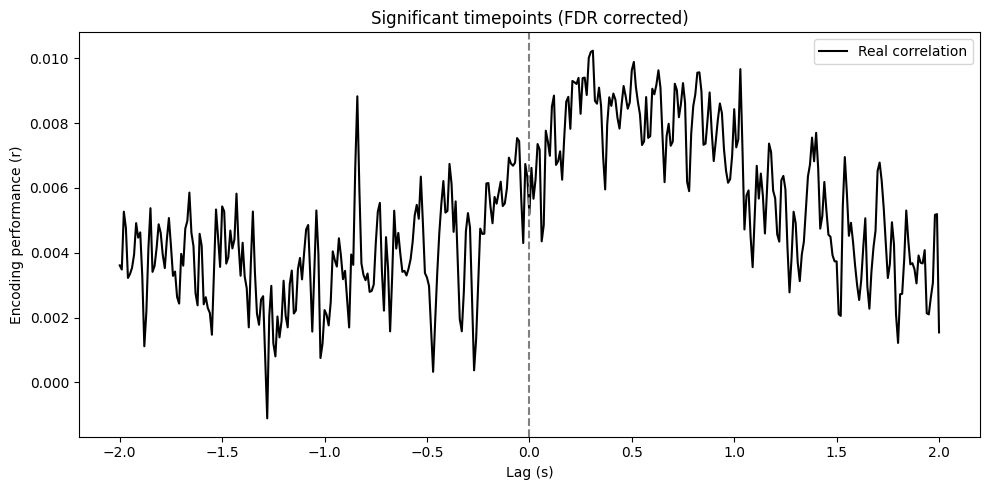

In [88]:
plot_timecourse(corrs_list, ch_masks, tp_masks, tp_thresh=1.0)

In [73]:
real_corr_ch = get_mean_channel_corrs(corrs_list, ch_masks, tp_masks)

Reading 0 ... 409999  =      0.000 ...   409.999 secs...


/home/matteoc/spect-to-meg/new_code/param_funct.py:61: RuntimeWarning: participants.tsv file not found for /srv/nfs-data/sisko/matteoc/meg/MEG_DATA/osfstorage/sub-13/ses-0/meg/sub-13_ses-0_task-0_meg.con
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


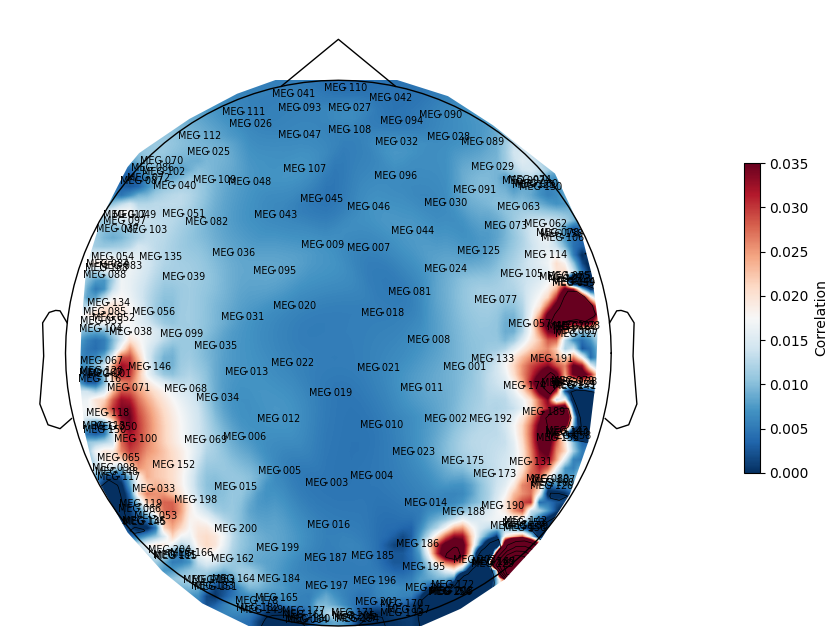

In [75]:
from param_funct import get_bids_raw
import mne

def get_topomap(raw, correlations, vlim, cmap='RdBu_r', sphere=0.13, extrapolate='local', 
                image_interp='cubic', threshold=None, size=8.5, label_to_set='Correlation'):
    meg_indices = mne.pick_types(raw.info, meg=True)
    meg_channel_positions = np.array([raw.info['chs'][i]['loc'][:2] for i in meg_indices])
    print('meg_channel_positions.shape: ', meg_channel_positions.shape)
    correlations = np.array(correlations).reshape(-1)
    print('correlations.shape: ', correlations.shape)
    if threshold is not None:
        correlations = np.where(correlations > threshold, correlations, np.nan)
    fig, ax = plt.subplots()
    topomap = mne.viz.plot_topomap(correlations, meg_channel_positions, ch_type='meg',
                                names=raw.info['ch_names'], sphere=sphere,
                                image_interp=image_interp, extrapolate=extrapolate,
                                border='mean', size=size, cmap=cmap, axes=ax, 
                                vlim=vlim, show=False)
    cbar = plt.colorbar(topomap[0], ax=ax, fraction=0.02, pad=0.1)   
    cbar.set_label(label_to_set)
    fig.set_size_inches(10, 8)  
    plt.show()


meg_path = '/srv/nfs-data/sisko/matteoc/meg'
raw = get_bids_raw(os.path.join(meg_path, 'MEG_DATA/osfstorage'), '13', '0', '0')
get_topomap(raw, real_corr_ch, vlim=(0, 0.035))